# Initial setup

## Install the libraries

In [1]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Cloning into 'bertviz_repo'...
fatal: unable to access 'https://github.com/jessevig/bertviz/': Could not resolve host: github.com


## Imports and definitions

In [2]:
import torch

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import logging
logging.set_verbosity_warning()

import numpy as np
import pprint

from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [3]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


# Model Explainability with BERT

https://github.com/PAIR-code/lit

https://github.com/jalammar/ecco

There are many models available at HuggingFace models repository. These are stable models that were made available by researchers and the industry.

https://huggingface.co/models

The example below is the most popular Transformer model, BERT, a cross-encoder trained on the Next Sentence Prediction task and Masked Language Model task:

In [8]:
model_path = 'deepset/roberta-base-squad2'

In [46]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
sentence_a = "Photosynthesis uses which energy?"
sentence_b = "Oxygen is released by photosynthesis, which uses the energy of sunlight."
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)


In [60]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

attention = outputs.attentions
hidden_states = outputs.hidden_states

## Visualization of embeddings

TypeError: fit() missing 1 required positional argument: 'X'

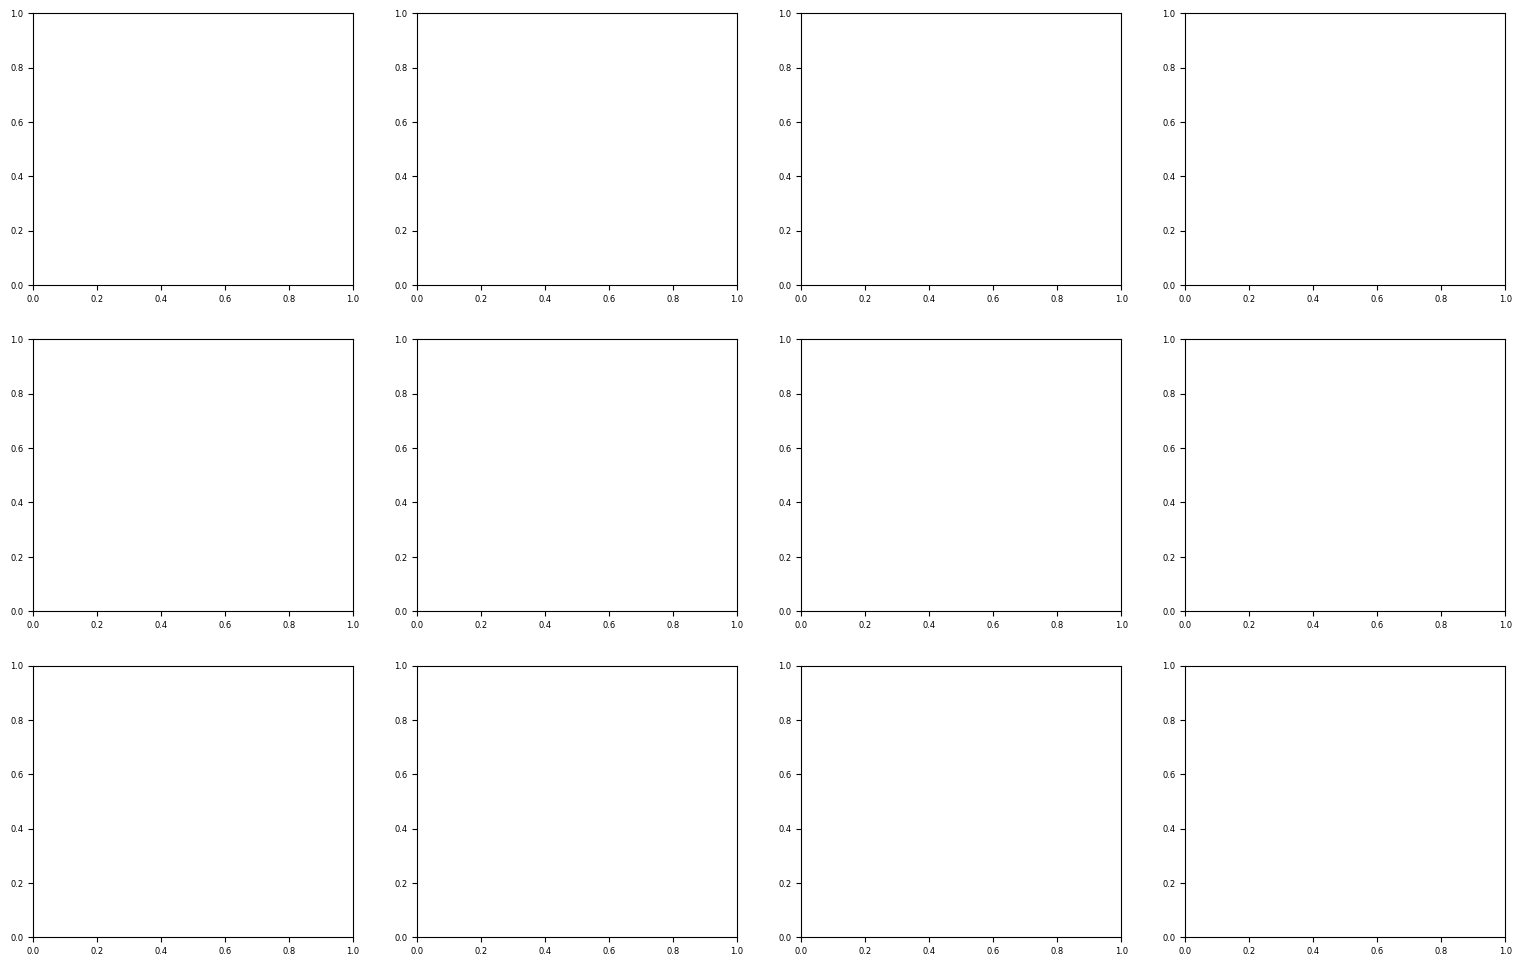

In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

## Token specific visualzation of self-attention

More details are available here: https://github.com/jessevig/bertviz

In [26]:
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## Visualization of all the attention heads in one layer

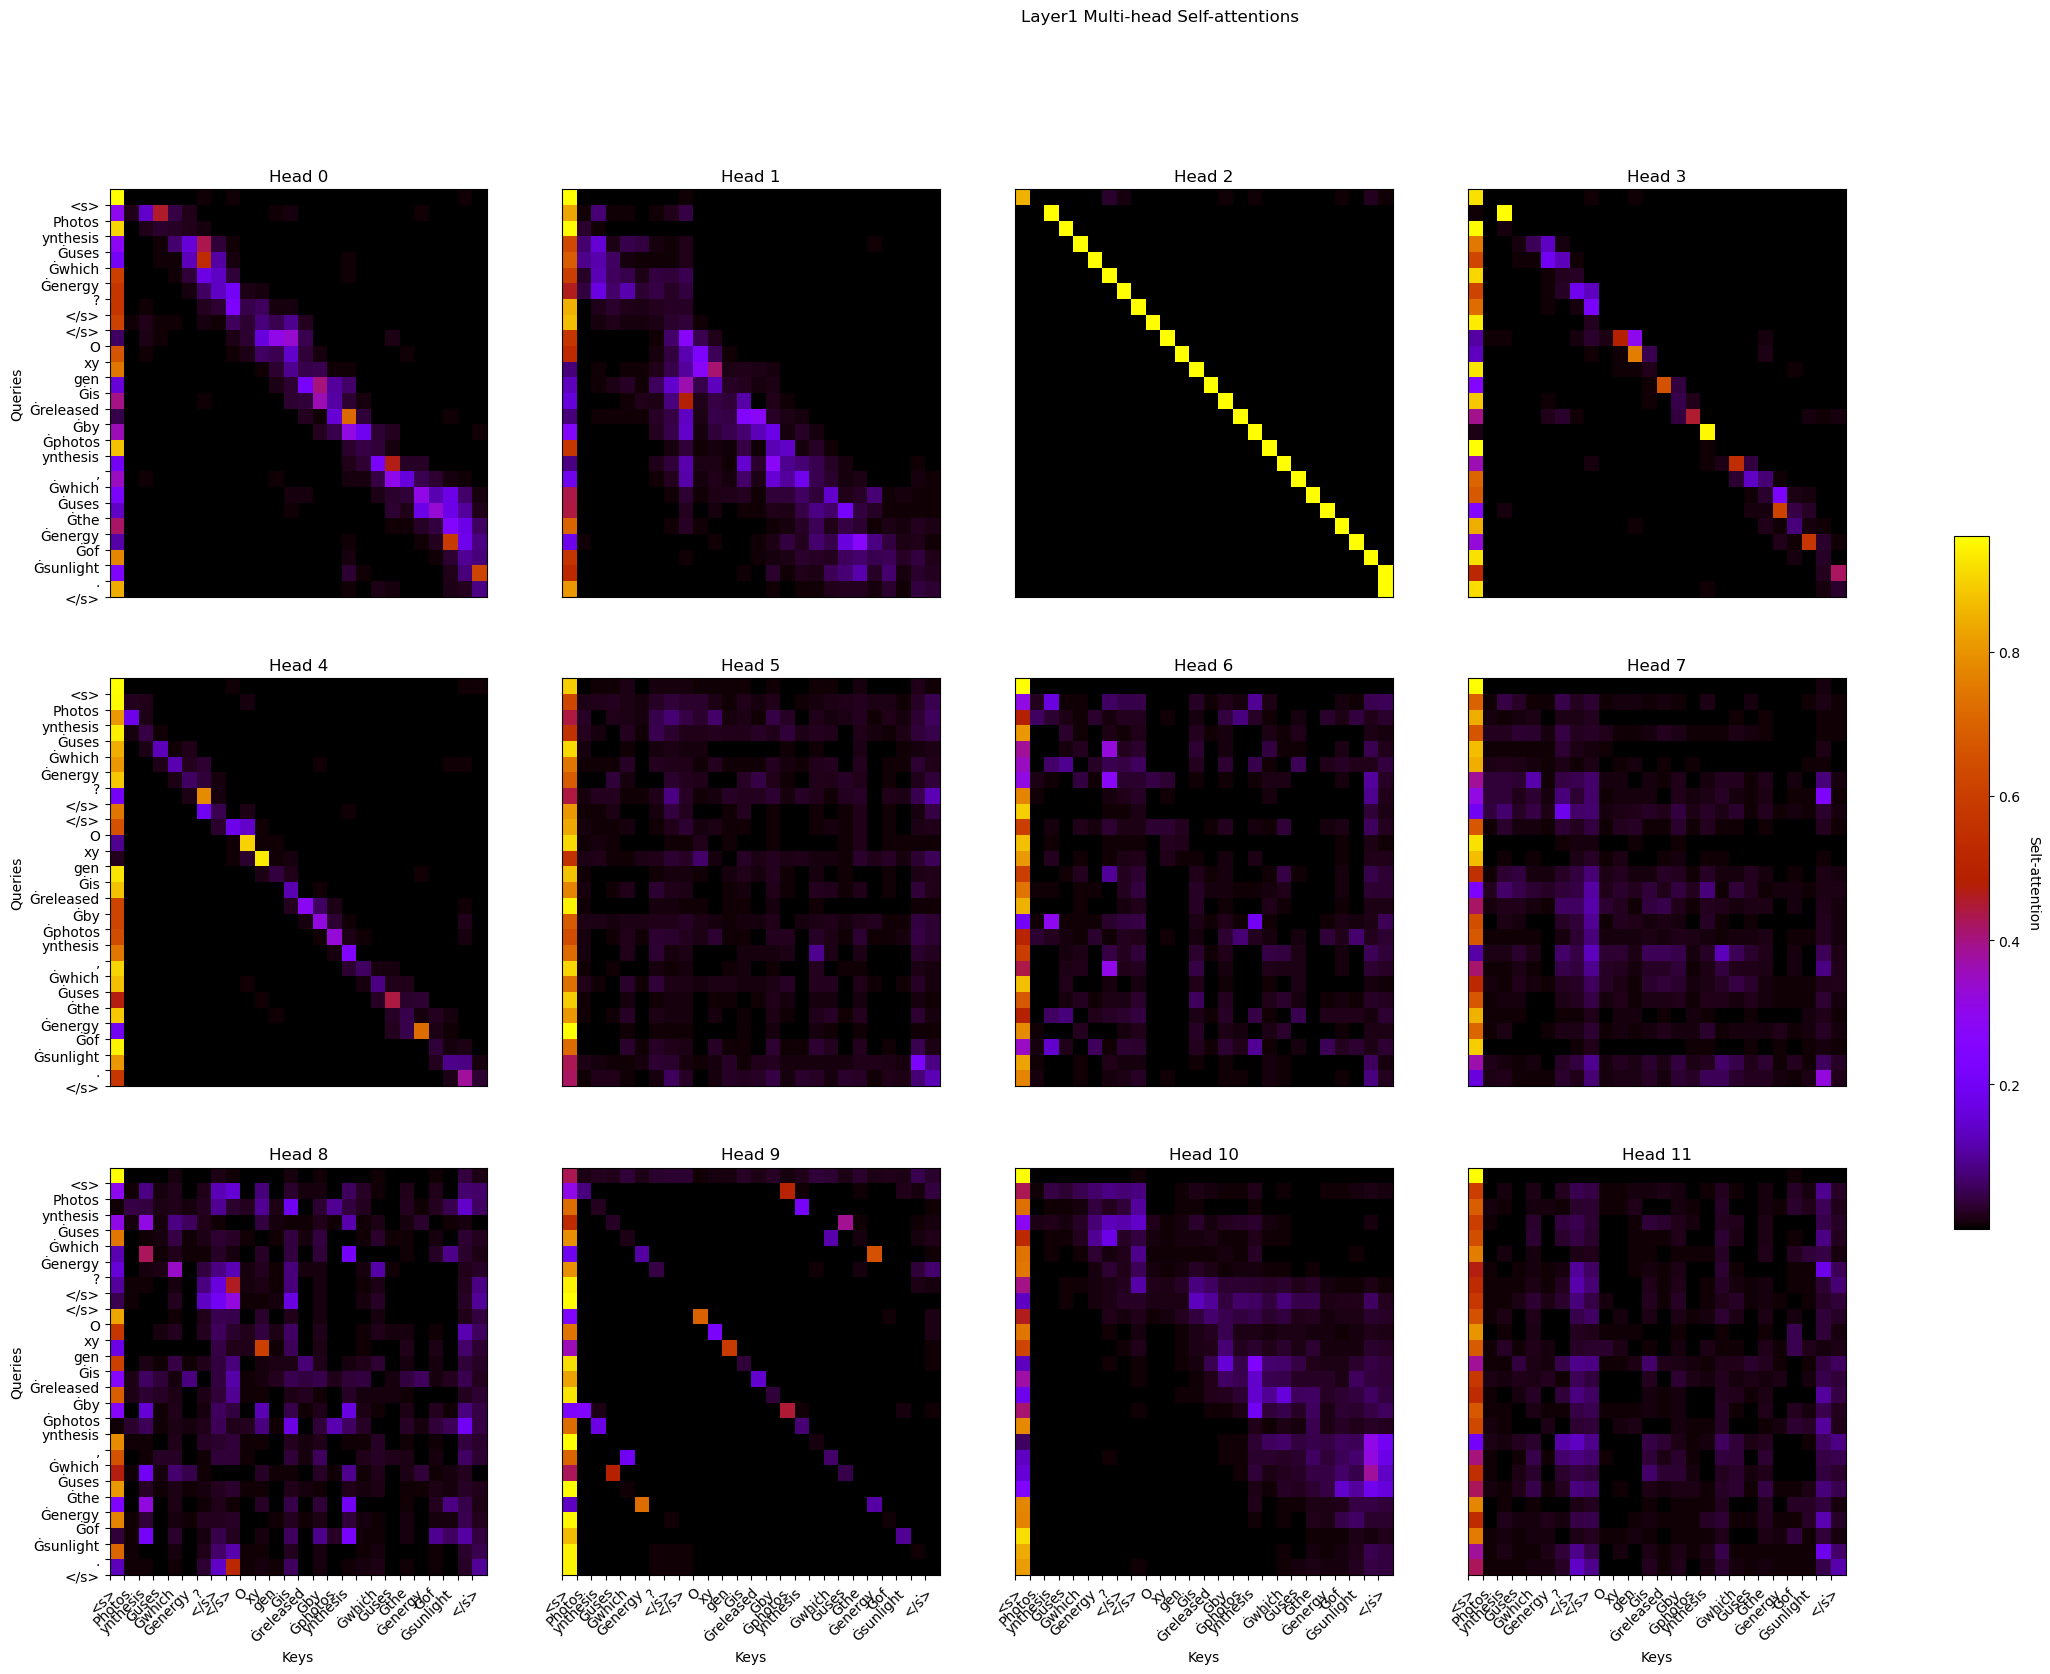

In [58]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

## Visualzation of Self-Attention in all layers and heads

In [39]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>